In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

import networkx as nx

from tqdm import tqdm

Loading the adjacency matrix and the sampled data

In [2]:
adjacency_matrix = np.load('adjacency_matrix.npy')

data_recipe = pd.read_json('processed_data.json').reset_index(drop=True)

In [3]:
data_recipe.head(5)

,directions,fat,date,categories,calories,protein,rating,title,ingredients,sodium
0,[Position rack in center of oven; preheat to 3...,27,2004-08-20 04:00:00,"[Cake, Food Processor, Mixer, Cheese, Dairy, E...",479,7,3.750,"Christmas Cranberry, Pear and Walnut Torte wit...","[orange, puree, cheese-orange, egg, frosting, ...",204
1,[Butter 11x7x2-inch glass baking dish. Sauté s...,46,2004-08-20 04:00:00,"[Onion, Pepper, Pork, Breakfast, Sauté, Parmes...",606,22,3.125,"Breakfast Polenta with Sausage, Onion and Peppers","[sausage, casing, bell, onion, cornmeal, butte...",968
2,"[Stir together butter, horseradish, dill, shal...",100,2007-05-17 19:43:26,"[Fish, Herb, Backyard BBQ, Dinner, Horseradish...",1305,92,4.375,Grilled Boneless Salmon Steaks with Horseradis...,"[horseradish, shallot, oil, string, salmon, bu...",923
3,[Cook bacon in a deep 12-inch heavy skillet ov...,71,2004-08-20 04:00:00,"[Chicken, Garlic, Braise, Vinegar, Bacon, Fall...",1086,81,3.750,"Braised Chicken with Shallots, Garlic, and Bal...","[shallot, slice, piece, head, strip, 1/2-lb, b...",485
4,[Cut off all peel and white pith from 3 blood ...,0,2007-10-02 19:13:35,"[Sauce, Food Processor, Side, No-Cook, Christm...",255,2,4.375,Cranberry and Blood Orange Relish,"[blood, orange, cranberry, sugar]",2


Plotting the adjacency matrix to see sparsity pattern

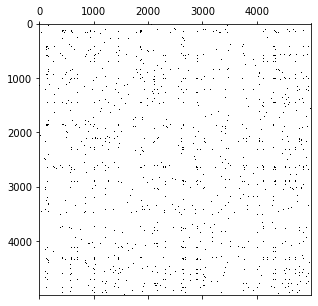

In [4]:
plt.figure(figsize=(5,5))
plt.spy(adjacency_matrix)
plt.show()

In [5]:
def describe_graph(G):
    """
    Helper function for printing various graph properties.
    
    Parameters
    ----------
    
    G: NetworkX graph object
        Graph
    """
    print(nx.info(G))
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
        
        # Number of connected components.
        comp = list(nx.connected_components(G))
        print('The graph contains', len(comp), 'connected components')
        
        # Largest connected component properties.
        largest_comp = max(comp, key=len)
        percentage_lcc = len(largest_comp)/G.number_of_nodes() * 100
        print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes')
        lcc_G = G.subgraph(largest_comp)
        print("The diameter of the largest connected component is", nx.diameter(lcc_G))
        print("The avg shortest path length of the largest connected component is", nx.average_shortest_path_length(lcc_G))
        
        # Smallest connected component properties.
        smallest_comp = min(comp, key=len)
        percentage_scc = len(smallest_comp)/G.number_of_nodes() * 100
        print('The smallest component has', len(smallest_comp), 'nodes', 'accounting for %.2f'% percentage_scc, '% of the nodes')
        scc_G = G.subgraph(smallest_comp)
        print("The diameter of the smallest connected component is", nx.diameter(scc_G))
        print("The avg shortest path length of the smallest connected component is", nx.average_shortest_path_length(scc_G))
        
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

Let's create a graph object from our adjacency matrix

In [6]:
graph = nx.from_numpy_array(adjacency_matrix)

Now, let's add attributes to our graph's nodes

In [7]:
nx.set_node_attributes(graph, data_recipe['title'].to_dict(), 'title')
nx.set_node_attributes(graph, data_recipe['protein'].to_dict(), 'protein')
nx.set_node_attributes(graph, data_recipe['fat'].to_dict(), 'fat')
nx.set_node_attributes(graph, data_recipe['sodium'].to_dict(), 'sodium')
nx.set_node_attributes(graph, data_recipe['calories'].to_dict(), 'calories')
nx.set_node_attributes(graph, data_recipe['rating'].to_dict(), 'rating')
nx.set_node_attributes(graph, data_recipe['ingredients'].to_dict(), 'ingredients')

In [8]:
# this takes a couple of hours to run
describe_graph(graph)

Name: 
Type: Graph
Number of nodes: 5000
Number of edges: 230352
Average degree:  92.1408
Graph is not connected
Diameter and Avg shortest path length are not defined!
The graph contains 29 connected components
The largest component has 4972 nodes accounting for 99.44 % of the nodes
The diameter of the largest connected component is 7
The avg shortest path length of the largest connected component is 2.729762954986063
The smallest component has 1 nodes accounting for 0.02 % of the nodes
The diameter of the smallest connected component is 0
The avg shortest path length of the smallest connected component is 0
Sparsity: 0.0184
Global clustering coefficient aka Transitivity: 0.3363


Most of the nodes are in the giant/largest component, which is often the case in a graph.

In [9]:
# Which nodes/recipes contain the most common ingredients.
degrees = dict(graph.degree(graph.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# The top 5 most connected nodes/recipes.
for recipe, degree in sorted_degree[:5]:
    print('Node', '#' + str(recipe), 'which is', "'" + graph.node[recipe]['title'] + "'", 'has common ingredients with', str(degree), 'recipes.')
    print('It contains the following ingredients:', graph.node[recipe]['ingredients'], '\n')

Node #463 which is 'Lemon Tea Cake with Blueberry-Red Wine Sauce' has common ingredients with 638 recipes.
It contains the following ingredients: ['wine', 'vanilla', 'blueberry', 'powder', 'oil', 'egg', 'juice', 'butter', 'cream', 'sugar', 'water', 'ground', 'peel', 'soda'] 

Node #700 which is 'Classic Lemon Cheesecake' has common ingredients with 624 recipes.
It contains the following ingredients: ['flour', 'cheese', 'egg', 'lemon', 'juice', 'butter', 'cream', 'sugar', 'water', 'vanilla', 'superfine'] 

Node #2469 which is 'Orange-Spice Bûche de Noël with Orange Cream Cheese Frosting' has common ingredients with 597 recipes.
It contains the following ingredients: ['extract', 'vanilla', 'apple', 'powder', 'orange', 'cider', 'cheese', 'vinegar', 'egg', 'juice', 'butter', 'cream', 'sugar', 'water', 'ground', 'peel', 'milk'] 

Node #4969 which is 'Sticky Date Pudding with Toffee Sauce' has common ingredients with 594 recipes.
It contains the following ingredients: ['date', 'vanilla', 'po

So the recipes which have most common ingredients with other recipes are:
- Lemon Tea Cake with Blueberry-Red Wine Sauce
- Classic Lemon Cheesecake
- Orange-Spice Bûche de Noël with Orange Cream Cheese Frosting
- Sticky Date Pudding with Toffee Sauce
- Cinnamon Coffee Cake Kotniuk

By looking at their ingredients one can conclude that among the most common ingredients we can name:
- egg
- water
- sugar
- butter
- cream

As can observe all of the 5-most connected recipe nodes are desserts.

In [10]:
def plot_degree_distribution(G, log_log=False):
    """
    Helper function for plotting the degree distribution of the graph.
    
    Parameters
    ----------
    
    G: NetworkX graph object
        Graph
    """
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots(figsize=(28,10))
    plt.bar(deg, cnt, width=0.80, color='b')
    if log_log:
        plt.yscale('log')
        plt.xscale('log')
        plt.title("Degree Distribution (log-log plot)")
    else:
        plt.title("Degree Distribution")
        ax.set_xticks([d+0.05 for d in deg if d%13==0])
    plt.ylabel("Frequency")
    plt.xlabel("Degree")

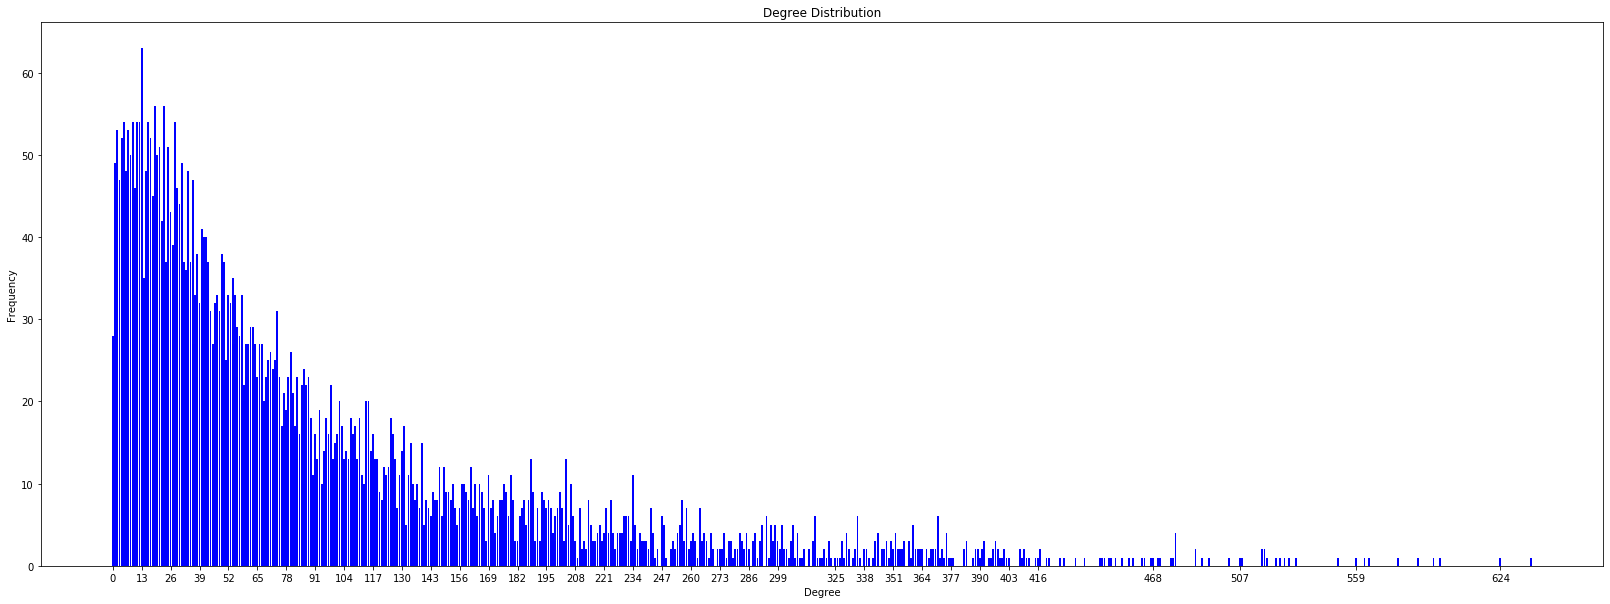

In [11]:
plot_degree_distribution(graph)

The degree distribution of the network seems to follow a power law. Let's also take a look at the log-log plot to see if our nework is scale free or not.

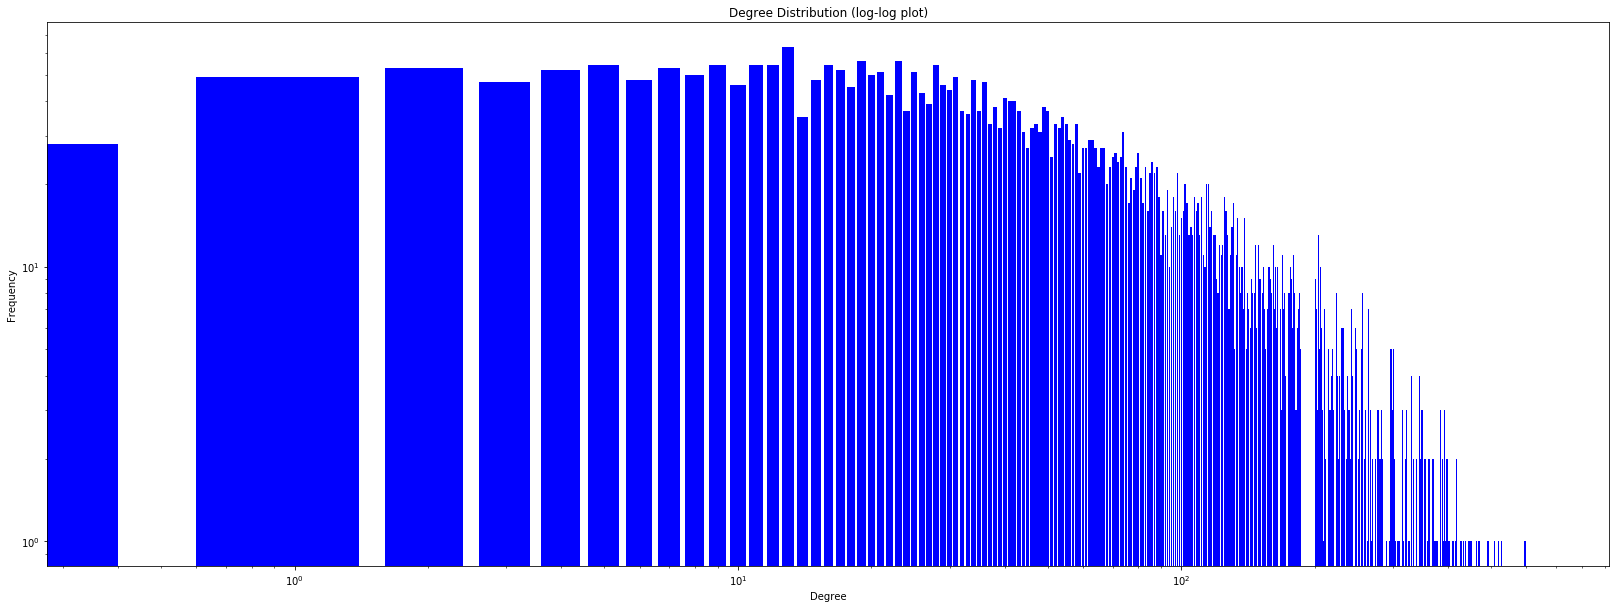

In [12]:
plot_degree_distribution(graph,log_log=True)

As we can observe from the log-log plot, our network has degree distribution closer to a log-normal rather than a power law (in case of power law we should have obtained a straight line).

In [13]:
print('Average clustering coefficient:', nx.average_clustering(graph))

Average clustering coefficient: 0.31527120652048074
